# 필요한 라이브러리 import

In [16]:
import pandas as pd
import os
import re
import csv
import numpy as np
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import defaultdict
plt.rc('font', family='Malgun Gothic') 
plt.rc('font', size=10)
warnings.filterwarnings("ignore")

# 선수의 포지션을 예측하는 모델 생성

## 데이터 전처리

In [17]:
# csv 파일을 불러와 데이터 프레임 생성
# 이 데이터는 선수의 포지션을 공격,미드필더,수비 세부분으로 라벨링을 한 데이터입니다.
position_df = pd.read_csv('./datas/포지션판별모델생성용데이터.csv',encoding='utf-8')

# 자료형 변경
position_df['승'].dtypes == 'int64'

# 사용할 칼럼만 선택
use_col = ['이름', '구분', '경기 당 드리블', '기회 창출/90', '경기당 유효 슈팅/90',
           '경기당 슈팅/90', 'Int/90', '공중 A/90', '경기당 헤더 성공', '태클', 
           '경기당 패스 시도/90','경기당 패스 성공/90', 'K Ps/90']

# 필요한 행만 추출
position_df = position_df[use_col]
position_df = position_df.drop(index = position_df[position_df['구분'].isna()].index)
position_df = position_df.reset_index(drop=True)


# 포지션 수치형 변경
def position_label(x):
    if x == '미드필더':
        return 0   
    elif x == '수비수':
        return 1    
    else:
        return 2

position_df['구분'] = position_df['구분'].map(position_label)

## RandomForest 모델 생성

### GridSearchCV를 통해 최적의 하이퍼파라미터 찾기

In [18]:
X,Y = position_df.iloc[:,2:],position_df.loc[:,'구분']

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

rf_params = {
        "criterion" : ['gini','entropy'],
        "n_estimators" : [100,250,500,750],
        "oob_score" : [True,False],
        "n_jobs" : [-1],
        "random_state" : [123],
        "class_weight" : ['balanced','balanced_subsample',None]
}

rf_model = RandomForestClassifier(
        oob_score=True,
        n_jobs = -1,
        random_state=123)

grid_tree = GridSearchCV(rf_model,param_grid=rf_params,cv=15,refit=True)

grid_tree.fit(x_train, y_train)

y_predict = grid_tree.predict(x_test)

print('best params : ',grid_tree.best_params_)

print('accuracy_score : ', accuracy_score(y_test,y_predict))

best params :  {'class_weight': None, 'criterion': 'gini', 'n_estimators': 250, 'n_jobs': -1, 'oob_score': True, 'random_state': 123}
accuracy_score :  0.88


### 최적의 하이퍼파라미터를 이용해서 모델 학습 with k_fold

In [19]:
split_count = 10

kf = KFold(n_splits= split_count)
kf.get_n_splits(X)

# 모델들을 저장할 리스트
rf_model_list = []

# 모델 정확도를 저장할 리스트
rf_acc_score_list = []

for train_index, test_index in kf.split(X):

    x_train, x_test = X.values[train_index], X.values[test_index]
    y_train, y_test = Y.values[train_index], Y.values[test_index]
    
    created_model = RandomForestClassifier(
        n_estimators = 250,
        oob_score=True,
        n_jobs = -1,
        random_state=123)
    
    created_model.fit(x_train, y_train)
    
    pred = created_model.predict(x_test)
    
    rf_acc_score_list.append(accuracy_score(y_test, pred))
        
    rf_model_list.append(created_model)

In [20]:
# 정확도
rf_acc_score_list

[0.88, 0.92, 0.94, 0.78, 0.78, 0.86, 0.9, 0.92, 0.84, 0.8]

In [21]:
# 최대 정확도의 모델을 선택
best_rf_model = rf_model_list[np.argmax(rf_acc_score_list)]

In [22]:
# 예측모델 저장
joblib.dump(best_rf_model,'./models/position_model.pkl')

['./models/position_model.pkl']

In [23]:
# 실제 나의 생각과 예측된 포지션을 비교
real_predicted = best_rf_model.predict(position_df.iloc[:,2:])
position_df['예측 포지션'] = real_predicted

def position_label_reverse(x):
    if x == 0:
        return '미드필더'
    
    elif x == 1:
        return '수비수'
    
    else:
        return '공격수'


position_df['예측 포지션'] = position_df['예측 포지션'].map(position_label_reverse)
position_df['구분'] = position_df['구분'].map(position_label_reverse)

position_df[position_df['구분']!=position_df['예측 포지션']]

,이름,구분,경기 당 드리블,기회 창출/90,경기당 유효 슈팅/90,경기당 슈팅/90,Int/90,공중 A/90,경기당 헤더 성공,태클,경기당 패스 시도/90,경기당 패스 성공/90,K Ps/90,예측 포지션
106,Jack Cork,수비수,0.13,0.35,0.22,0.61,1.06,4.64,3.01,2.40,55.39,51.52,0.83,미드필더
108,Maxwel Cornet,공격수,1.69,0.18,0.36,0.78,1.63,6.82,3.92,3.56,35.25,30.97,1.63,미드필더
142,Oriol Romeu,수비수,0.12,0.49,0.15,0.35,1.08,4.42,3.46,1.80,52.30,47.36,0.99,미드필더


# 포지션 EDA

In [24]:
best_rf_model.feature_importances_

array([0.05990027, 0.02118918, 0.09664802, 0.07816806, 0.04478403,
       0.07799309, 0.11437123, 0.05162883, 0.13182363, 0.17981216,
       0.1436815 ])

In [26]:
feature_importance_dict = defaultdict(float)

for feature,importance in zip(list(position_df.columns[2:-1]),best_rf_model.feature_importances_):
    feature_importance_dict[feature] = importance
    
sorted(feature_importance_dict.items(),key=lambda x : x[1], reverse=True)

[('경기당 패스 성공/90', 0.17981215945056642),
 ('K Ps/90', 0.14368150327511395),
 ('경기당 패스 시도/90', 0.13182362512611756),
 ('경기당 헤더 성공', 0.1143712318639467),
 ('경기당 유효 슈팅/90', 0.09664802126484134),
 ('경기당 슈팅/90', 0.07816805783108437),
 ('공중 A/90', 0.07799308646040812),
 ('경기 당 드리블', 0.059900267815742425),
 ('태클', 0.051628828614623236),
 ('Int/90', 0.04478403376913679),
 ('기회 창출/90', 0.021189184528419117)]

<Figure size 720x720 with 0 Axes>

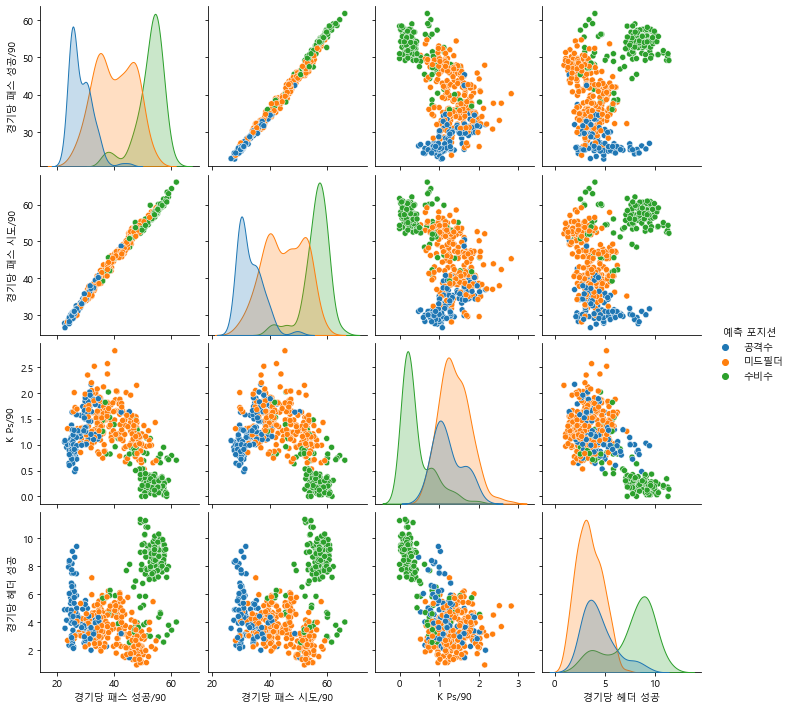

In [53]:
plt.figure(figsize=(10,10))
sns.pairplot(position_df[['경기당 패스 성공/90','경기당 패스 시도/90','K Ps/90','경기당 헤더 성공','예측 포지션']],hue='예측 포지션')
plt.show()

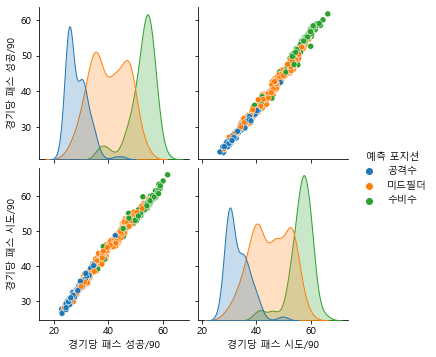

In [54]:
sns.pairplot(position_df[['경기당 패스 성공/90','경기당 패스 시도/90','예측 포지션']],hue='예측 포지션')

In [55]:
pre_forward_df = position_df[position_df['예측 포지션'] == '공격수']

In [59]:
pre_forward_df[pre_forward_df['경기당 패스 성공/90']>45]

,이름,구분,경기 당 드리블,기회 창출/90,경기당 유효 슈팅/90,경기당 슈팅/90,Int/90,공중 A/90,경기당 헤더 성공,태클,경기당 패스 시도/90,경기당 패스 성공/90,K Ps/90,예측 포지션
332,Phil Foden,공격수,0.99,0.46,0.97,2.33,1.18,3.25,1.45,1.43,50.45,45.38,1.64,공격수


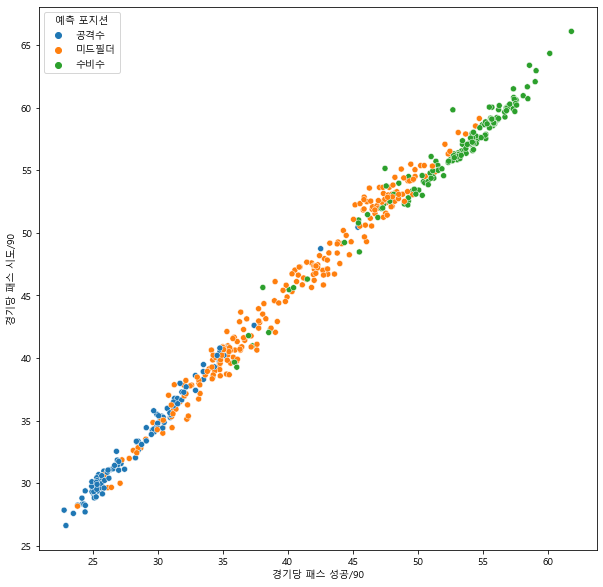

In [60]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=position_df[['경기당 패스 성공/90','경기당 패스 시도/90','예측 포지션']],x='경기당 패스 성공/90',y='경기당 패스 시도/90',hue='예측 포지션')

plt.show()